# Introduction

In this notebook, we will implement the standard method of Collaborative Filtering with the Pareto Dominance. It is inspired by this paper: 
http://www.sciencedirect.com/science/article/pii/S0020025513002004

In [1]:
# Import the fucking useful libraries =)
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from helpers_CF_and_PD import *
import scipy.stats as sp
import scipy.spatial.distance as spsd
from operator import itemgetter
import random
from IPython import display

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

In [2]:
# Define here the data set
dataset = '../data/data_train.csv'

# Load the data and prepare them


In [3]:
data = prepare_data(dataset)
# Prepare the data
U, I, R, I_u = variables(data)

Load the dataset
Prepare the variables


Get the sets of non-dominated users. (Already calculated)

In [4]:
# Folder for the preprocessing file
folder = "./pickles/"

non_dom_users_file = folder + "C/non-dominated-users.pickle"

# Get the file
C = get_pickle(non_dom_users_file)

# Make some tests

In order to make sure that the preprocessing is correct, we need to plot some graph

In [ ]:
# We define an array of values equals to number of candidates over number of items rated
c_over_ir = []
nbr_cand = []
nbr_itms = []
for usr in U:
    c_over_ir.append(len(C[usr])/len(I_u[usr]))
    nbr_cand.append(len(C[usr]))
    nbr_itms.append(len(I_u[usr]))
len(c_over_ir)

In [ ]:
n, bins, patches = plt.hist(c_over_ir, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of candidates / Number of items rated')
plt.ylabel('Number of users')

In [ ]:
n, bins, patches = plt.hist(nbr_cand, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of candidates')
plt.ylabel('Number of users')

In [ ]:
n, bins, patches = plt.hist(nbr_itms, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of items rated')
plt.ylabel('Number of users')

In [ ]:
nbr_itms.index(min(nbr_itms))

In [ ]:
len(C[480])

In [ ]:
nbr_cand.index(min(nbr_cand))

In [ ]:
nbr_itms[3677]

Difficult to say if it worked or not.. But it seems ok... =)

# Nearest Neighbors

Now, we create the list of arrays of nearest neighbors for each user using the three different functions

In [ ]:
%%time
NN_pearson_file, sim_pearson_file = nearest_neighbors(folder, R, U, I_u, "pearson", subset=C)


In [ ]:
%%time
NN_cosine_file, sim_cosine_file = nearest_neighbors(folder, R, U, I_u, "cosine", subset=C)


In [ ]:
%%time
NN_msd_file, sim_msd_file = nearest_neighbors(folder, R, U, I_u, "msd", subset=C)


In [ ]:
NN_pearson_file = folder + "NN_pearson.pickle"
NN_cosine_file = folder + "NN_cosine.pickle"
NN_msd_file = folder + "NN_msd.pickle"
NN_files = [NN_pearson_file, NN_cosine_file, NN_msd_file]

sim_pearson_file = folder + "sim_pearson.pickle"
sim_cosine_file = folder + "sim_cosine.pickle"
sim_msd_file = folder + "sim_msd.pickle"
sim_files = [sim_pearson_file, sim_cosine_file, sim_msd_file]


# Training

Now, we just have to do the training. First, we cut into training and testing data.

In [5]:
# Before having the train and testing set, we need to unload the memory a bit
del C
del U
del I
del R
del I_u

In [6]:
def training_validation(data, p_value=0.1):
    validation_array = []
    train_array = []
    for i in range(len(data)):
        if random.random() < p_value:
            validation_array.append(data.iloc[i])
        else:
            train_array.append(data.iloc[i])
            
    variables = list(train_array[0].keys())
    
    train = pd.DataFrame([[getattr(i,j) for j in variables] for i in train_array], columns = variables)
    validation = pd.DataFrame([[getattr(i,j) for j in variables] for i in validation_array], columns = variables)

    return train, validation            

In [7]:
train, validation = training_validation(data, p_value=0.01)

In [8]:
# Create training matrices
U_train, I_train, R_train, I_u_train = variables(data)

Prepare the variables


In [9]:
KK = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 2000]

In [10]:
def rmse(a,b):
    return np.sqrt(np.mean((np.array(a)-np.array(b))**2))

def mean(i, R, R_G):
    if len(R_G) == 0:
        ratings = R[:,i]
        return np.mean(ratings[ratings!=np.inf])
    else:
        return np.mean(R_G)
    
def weighted_mean(u, i, neigh, sim, R, R_G):
    if len(R_G) == 0:
        ratings = R[:,i]
        return np.mean(ratings[ratings!=np.inf])
    else:
        return np.sum(sim*R_G)/sum(sim)
    
def deviation_from_mean(u, i, neigh, sim, R, R_G):
    if len(R_G) == 0:
        ratings = R[:,i]
        return np.mean(ratings[ratings!=np.inf])
    else:
        ratings = R[u,:]
        rating_u_mean = np.mean(ratings[ratings!=np.inf])
        deviation = 0
        for i in range(len(R_G)):
            rate_n = R[neigh[i],:]
            deviation += sim[i]*(R_G[i]-np.mean(rate_n[rate_n!=np.inf]))
        
        return rating_u_mean + deviation/np.sum(sim)

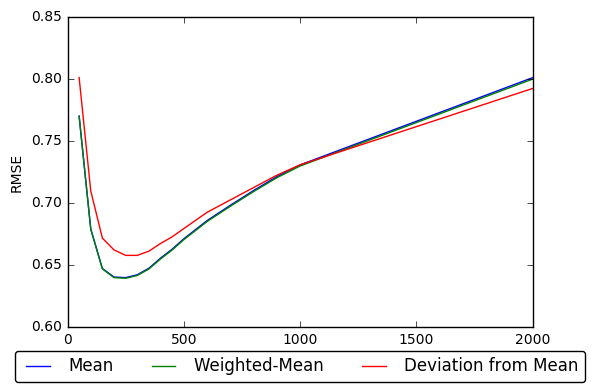

In [12]:
# Test for MSD
RMSE = np.zeros((3, len(KK)))

for idx, k in enumerate(KK):
    n = len(validation)
    ratings = np.zeros((3, n))
    pred = np.zeros(n)
    prev_usr = 99999
    for i in range(n):
        pred[i] = validation.iloc[i].loc["Prediction"]
        usr = validation.iloc[i].loc["UserID"]
        movie = validation.iloc[i].loc["MovieID"]
        # KNN
        if usr != prev_usr:
            NN = get_pickle(folder + "NN/NN_" + str(usr) + "_msd.pickle")
            similarity = get_pickle(folder + "sim/sim_" + str(usr) + "_msd.pickle")
        
        prev_usr = usr
        
        if k>len(NN):
            neigh = np.array(NN)
            sim = np.array(similarity)
        else:
            neigh = np.array(NN[:k])
            sim = np.array(similarity[:k])
        
        # Prepare Ratings of G
        R_G = R_train[neigh, movie]          
        G = R_G!=np.inf
        R_G = R_G[G]
        neigh = neigh[G]
        sim = sim[G]
        # Put ratings
        ratings[0,i] = mean(movie, R_train, R_G)
        ratings[1,i] = weighted_mean(usr, movie, neigh, sim, R_train, R_G)
        ratings[2,i] = deviation_from_mean(usr, movie, neigh, sim, R_train, R_G)
        #if (i+1)%1000 == 0:
        #    print("%i/%i done!"%(i+1, n))
    RMSE[0, idx] = rmse(ratings[0,:], pred)
    RMSE[1, idx] = rmse(ratings[1,:], pred)
    RMSE[2, idx] = rmse(ratings[2,:], pred)
    plt.gca().cla() 
    plt.plot(KK, RMSE[0,:], label='Mean')
    plt.plot(KK, RMSE[1,:], label='Weighted-Mean')
    plt.plot(KK, RMSE[2,:], label='Deviation from Mean')
    plt.xlabel("k")
    plt.ylabel("RMSE")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [13]:
np.min(RMSE, axis=1)

array([ 0.63969886,  0.63915856,  0.65762036])

In [18]:
best_k = KK[np.argmin(RMSE[1,:])]
best_k

250

# Testing

Load the test data and apply the Recommendation

In [51]:
# Test data
dataset_test = '../../data/sampleSubmission.csv'
data_test = prepare_data(dataset_test)

# Training data
data = prepare_data(dataset)
# Prepare the data
U, I, R, I_u = variables(data)

Load the dataset
Load the dataset
Prepare the variables


In [52]:
data_test.head()

,Id,Prediction,UserID,MovieID
0,r37_c1,3,36,0
1,r73_c1,3,72,0
2,r156_c1,3,155,0
3,r160_c1,3,159,0
4,r248_c1,3,247,0


In [53]:
data_test = data_test.sort(["UserID"])
data_test.head()

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Id,Prediction,UserID,MovieID
598694,r1_c499,3,0,498
307346,r1_c256,3,0,255
528307,r1_c455,3,0,454
350308,r1_c297,3,0,296
902759,r1_c706,3,0,705


In [54]:
pred = []
prev_usr = 99999
done = 0
best_k = 1000
for i in range(len(data)):
    usr = data_test.iloc[i].loc["UserID"]
    movie = data_test.iloc[i].loc["MovieID"]
        
    # KNN
    if usr != prev_usr:
        NN = get_pickle(folder + "NN/NN_" + str(usr) + "_msd.pickle")
        similarity = get_pickle(folder + "sim/sim_" + str(usr) + "_msd.pickle")

    prev_usr = usr

    if k>len(NN):
        neigh = np.array(NN)
        sim = np.array(similarity)
    else:
        neigh = np.array(NN[:k])
        sim = np.array(similarity[:k])

    # Prepare Ratings of G
    R_G = R_train[neigh, movie]          
    G = R_G!=np.inf
    R_G = R_G[G]
    neigh = neigh[G]
    sim = sim[G]
    
    pred.append(deviation_from_mean(usr, movie, neigh, sim, R_train, R_G))
    done += 1
    if (done)%100000 == 0:
        print("%i/%i done!"%(done, len(data_test)))
print("All done!")

100000/1176952 done!
200000/1176952 done!
300000/1176952 done!
400000/1176952 done!
500000/1176952 done!
600000/1176952 done!
700000/1176952 done!
800000/1176952 done!
900000/1176952 done!
1000000/1176952 done!
1100000/1176952 done!
All done!


In [58]:
for i in range(len(pred)):
    if pred[i] > 5:
        pred[i] = 5
    elif pred[i] < 1:
        pred[i] = 1
    else:
        pred[i] = round(pred[i])


In [59]:
data_test['Prediction'] = pred
data_test = data_test.sort(["MovieID", "UserID"])
data_test.head()

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Id,Prediction,UserID,MovieID
0,r37_c1,4.0,36,0
1,r73_c1,5.0,72,0
2,r156_c1,4.0,155,0
3,r160_c1,4.0,159,0
4,r248_c1,4.0,247,0


In [60]:
data_test = data_test.drop(['UserID', 'MovieID'], axis=1)

In [61]:
data_test.to_csv('pred_PD_CF.csv', index=False)

In [62]:
data_test.head()

,Id,Prediction
0,r37_c1,4.0
1,r73_c1,5.0
2,r156_c1,4.0
3,r160_c1,4.0
4,r248_c1,4.0
